# Boston Marathon Results with Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [3]:
raw_df = pd.read_csv('results.csv')
raw_df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [12]:
raw_df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


The primary features we're looking at here are 'official' (final time), age, gender, and country. The split times are badly formatted and aren't worth cleaning up for this first look at the data. Most of the other features are rankings and bib numbers, which we don't really care about (or can be derived from other data). Let's put all those into a dataset and one hot encode the countries.

In [24]:
# Get the useful columns
df = raw_df.loc[:, ['official', 'age', 'gender', 'country']]

# Switch from M/F to 0 for Male, 1 for Female
df.gender = np.where(df.gender == 'M', 0, 1)

# Get Dummies on Country Feature
df = pd.get_dummies(df)

df.head()

,official,age,gender,country_ARG,country_AUS,country_AUT,country_BAH,country_BAR,country_BEL,country_BER,...,country_TPE,country_TRI,country_TUR,country_UAE,country_UKR,country_URU,country_USA,country_VEN,country_VGB,country_ZIM
0,85.25,47,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,138.95,33,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80.60,41,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,140.58,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,81.23,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, MiniBatchKMeans
from sklearn.model_selection import train_test_split

In [77]:
# Create arrays for modeling
X_train, X_test = train_test_split(df, test_size = .3)
print('Array shapes:', X_train.shape, X_test.shape)

Array shapes: (22388, 81) (9596, 81)


In [79]:
kmc = KMeans(n_clusters=10).fit(X_train)
labels = kmc.labels_

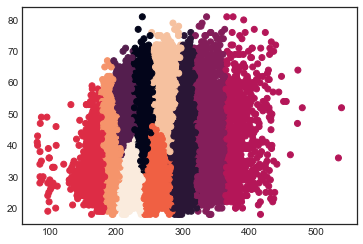

In [80]:
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=labels)
plt.show()

array([ 0.97065127,  0.9882969 ,  0.9905577 , ...,  0.99341277,
        0.98112555,  0.98487352])